In [ ]:
import os                      # For file path operations
import re                      # For text pattern matching and cleaning (e.g., removing digits)
import joblib                  # For saving/loading machine learning models efficiently
import numpy as np             # For numerical computations
import pandas as pd            # For data loading, manipulation, and analysis
import matplotlib.pyplot as plt   # For creating plots and charts
import seaborn as sns             # For statistical data visualization with prettier default styles
from sklearn.model_selection import (
    train_test_split,             # Splits the dataset into training and testing sets
    cross_val_score,              # Performs cross-validation and returns scores
    learning_curve                # Plots training vs validation performance
)
from sklearn.preprocessing import (
    StandardScaler,               # Standardizes features by removing the mean and scaling to unit variance
    LabelEncoder,                 # Encodes target labels with value between 0 and n_classes-1
    OneHotEncoder                 # Converts categorical variables into binary (one-hot) format
)
from sklearn.feature_extraction.text import CountVectorizer  # Converts text data into a matrix of token counts (used for k-mer encoding)
from sklearn.metrics import (
    classification_report,        # Generates a text report showing the main classification metrics
    accuracy_score,               # Measures the accuracy of predictions
    confusion_matrix,             # Computes confusion matrix to evaluate classification performance
    roc_curve,                    # Computes Receiver Operating Characteristic (ROC) curve
    auc                           # Computes Area Under the ROC Curve (AUC)
)
from sklearn.ensemble import (
    RandomForestClassifier,       # Ensemble method using decision trees (robust and interpretable)
    GradientBoostingClassifier    # Ensemble method using boosting (strong performance on structured data)
)
from sklearn.svm import SVC                         # Support Vector Classifier for binary/multiclass classification
from sklearn.naive_bayes import MultinomialNB       # Naive Bayes classifier for multinomially distributed data
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors algorithm
from xgboost import XGBClassifier                   # Gradient boosting model from the XGBoost library (high performance)
from sklearn.decomposition import PCA               # Principal Component Analysis (for reducing dimensionality)
from sklearn.feature_selection import SelectFromModel  # Select features based on importance weights
from sklearn.linear_model import Lasso              # Linear model used for regression and feature selection (L1 regularization)


In [ ]:
# Load Dataset
df = pd.read_csv('hvr1_cleaned_sequences.csv')

# 1. Uploading the dataset, then splitting it

In [ ]:
#Select Features and Target
X = df['HVR1']  # Only using HVR1 sequences
y = df['ethnicity']  # Ethnicity as the target variable

In [ ]:
# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode ethnicity labels (target) on training data
y_train_encoded = label_encoder.fit_transform(y_train)

# 2. data preprocessing

## 2.1 using kmers and one hot encoding for preprocessing

In [ ]:
def generate_kmer_features(sequences, k=4):
    """ Convert sequences into k-mer frequency features using CountVectorizer. """
    # Check if sequences is a DataFrame or Series
    if isinstance(sequences, pd.DataFrame):
        # If it's a DataFrame, use the first column
        sequences_list = sequences.iloc[:, 0].tolist()
    else:
        # If it's a Series, convert directly to list
        sequences_list = sequences.tolist()

    vectorizer = CountVectorizer(analyzer='char', ngram_range=(k, k))
    kmer_features = vectorizer.fit_transform(sequences_list)
    return kmer_features, vectorizer

def one_hot_encode_sequences(sequences):
    """ Convert nucleotide sequences into one-hot encoded format. """
    # Check if sequences is a DataFrame or Series
    if isinstance(sequences, pd.DataFrame):
        # If it's a DataFrame, use the first column
        sequences_list = sequences.iloc[:, 0].tolist()
    else:
        # If it's a Series, convert directly to list
        sequences_list = sequences.tolist()

    # Create arrays of character lists
    sequence_arrays = [list(seq) for seq in sequences_list]

    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
    onehot_features = encoder.fit_transform(np.array(sequence_arrays))
    return onehot_features, encoder
# K-mer Encoding (only on training data)
print("Generating K-mer features...")
X_train_kmer, kmer_vectorizer = generate_kmer_features(X_train)

# Feature Scaling for K-mer features (only on training data)
scaler_kmer = StandardScaler(with_mean=False)  # Preserve sparsity for sparse matrices
X_train_kmer_scaled = scaler_kmer.fit_transform(X_train_kmer)

# One-Hot Encoding (only on training data)
print("Generating One-Hot Encoded features...")
X_train_onehot, onehot_encoder = one_hot_encode_sequences(X_train)

# Evaluate encoding methods with Cross-validation
rf = RandomForestClassifier(random_state=42)

def evaluate_model(X_train, y_train, method_name):
    """ Perform 5-fold cross-validation and return mean accuracy. """
    scores = cross_val_score(rf, X_train, y_train_encoded, cv=5, scoring='accuracy')
    print(f"{method_name} Encoding - CV Scores: {scores}")
    print(f"{method_name} Encoding - Mean CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
    return scores.mean()

# Evaluate K-mer Encoding with CV
print("\nEvaluating K-mer Encoding...")
kmer_accuracy = evaluate_model(X_train_kmer, y_train, "K-mer")

# Evaluate One-Hot Encoding with CV
print("\nEvaluating One-Hot Encoding...")
onehot_accuracy = evaluate_model(X_train_onehot, y_train, "One-Hot")

# Select Best Encoding Method Based on Cross-Validation Results
best_method = "K-mer" if kmer_accuracy > onehot_accuracy else "One-Hot"
print(f"\nBest encoding method: {best_method}")
print(f"K-mer CV Accuracy: {kmer_accuracy:.4f}")
print(f"One-Hot CV Accuracy: {onehot_accuracy:.4f}")

Generating K-mer features...
Generating One-Hot Encoded features...

Evaluating K-mer Encoding...
K-mer Encoding - CV Scores: [0.875      0.91666667 0.89583333 0.9375     0.91666667]
K-mer Encoding - Mean CV Accuracy: 0.9083 ± 0.0212

Evaluating One-Hot Encoding...
One-Hot Encoding - CV Scores: [0.85416667 0.85416667 0.89583333 0.85416667 0.91666667]
One-Hot Encoding - Mean CV Accuracy: 0.8750 ± 0.0264

Best encoding method: K-mer
K-mer CV Accuracy: 0.9083
One-Hot CV Accuracy: 0.8750


In [ ]:
import pandas as pd

def save_kmers_to_file(vectorizer, kmer_features, output_file='kmer_frequencies.csv'):
    """ Save k-mers and their frequencies to a CSV file. """
    # Get k-mer names and their frequencies
    kmer_names = vectorizer.get_feature_names_out()
    kmer_frequencies = kmer_features.sum(axis=0).A1  # Sum frequencies across all sequences

    # Create a DataFrame with k-mers and their frequencies
    kmer_df = pd.DataFrame({'k-mer': kmer_names, 'frequency': kmer_frequencies})

    # Save k-mers and frequencies to a CSV file
    kmer_df.to_csv(output_file, index=False)
    print(f"K-mer frequencies saved to {output_file}")

# Example usage (assuming vectorizer and kmer_features are already defined)
save_kmers_to_file(kmer_vectorizer, X_train_kmer, output_file='kmer_frequencies.csv')

K-mer frequencies saved to kmer_frequencies.csv


## 2.2 using pca, rf feature selection, lasso and original dataset for feature selection

In [ ]:
# Convert sparse matrix to dense
X_train_kmer_scaled_dense = X_train_kmer_scaled.toarray()

# 1. PCA Component Selection based on explained variance
def select_pca_components(X, variance_thresholds=[0.8, 0.85, 0.9, 0.95, 0.99]):
    """Select PCA components based on explained variance thresholds."""
    # Fit PCA with maximum possible components
    pca_full = PCA()
    pca_full.fit(X)

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

    # Find number of components for each threshold
    selected_components = []
    for threshold in variance_thresholds:
        n_components = np.argmax(cumulative_variance >= threshold) + 1
        selected_components.append(n_components)

    print("\nPCA Component Selection:")
    print("Variance Threshold | Number of Components")
    print("-" * 40)
    for thresh, n_comp in zip(variance_thresholds, selected_components):
        print(f"{thresh*100:^16.1f}% | {n_comp:^18d}")

    # Perform PCA for each selected number of components
    results = []
    for n in selected_components:
        pca = PCA(n_components=n)
        X_pca = pca.fit_transform(X)
        results.append({
            'n_components': n,
            'variance_threshold': thresh,
            'cumulative_variance': np.sum(pca.explained_variance_ratio_),
            'pca_object': pca,
            'transformed_data': X_pca
        })
    return results

# 2. Feature Importance Selection based on importance distribution
def select_features_by_importance(X, rf_model, importance_thresholds=[0.8, 0.85, 0.9, 0.95, 0.99]):
    """Select features based on cumulative importance thresholds."""
    # Get feature importances
    importances = rf_model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    cumulative_importance = np.cumsum(importances[sorted_idx])

    # Find number of features for each threshold
    selected_features = []
    for threshold in importance_thresholds:
        n_features = np.argmax(cumulative_importance >= threshold) + 1
        selected_features.append(n_features)

    print("\nFeature Importance Selection:")
    print("Importance Threshold | Number of Features")
    print("-" * 40)
    for thresh, n_feat in zip(importance_thresholds, selected_features):
        print(f"{thresh*100:^18.1f}% | {n_feat:^17d}")

    # Select features for each threshold
    results = []
    for n in selected_features:
        selector = SelectFromModel(rf_model, max_features=n, prefit=True)
        X_selected = selector.transform(X)
        results.append({
            'n_features': n,
            'importance_threshold': thresh,
            'transformed_data': X_selected
        })
    return results
# 3. NEW: L1 Regularization (Lasso) for Feature Selection
def select_features_lasso(X, y, alpha_values=[0.01, 0.05, 0.1, 0.5, 1.0]):
    """Select features using Lasso regularization with different alpha values."""
    results = []

    print("\nLasso (L1) Regularization Feature Selection:")
    print("Alpha | Number of Features Selected")
    print("-" * 40)

    for alpha in alpha_values:
        # For regression problems
        lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
        lasso.fit(X, y_train_encoded)

        # Get selected features
        selected_features = np.where(lasso.coef_ != 0)[0]
        n_selected = len(selected_features)

        print(f"{alpha:^5.2f} | {n_selected:^24d}")

        # If no features were selected, skip this alpha
        if n_selected == 0:
            continue

        # Transform data to include only selected features
        X_selected = X[:, selected_features]

        results.append({
            'alpha': alpha,
            'n_features': n_selected,
            'feature_indices': selected_features,
            'transformed_data': X_selected
        })

    return results


# Train Random Forest for feature importance
rf_selector = RandomForestClassifier(random_state=42)
rf_selector.fit(X_train_kmer_scaled_dense, y_train_encoded)

# Get results for both methods
pca_results = select_pca_components(X_train_kmer_scaled_dense)
importance_results = select_features_by_importance(X_train_kmer_scaled_dense, rf_selector)
lasso_results = select_features_lasso(X_train_kmer_scaled_dense, y_train_encoded)

# Evaluate using Random Forest with 5-fold CV
rf_classifier = RandomForestClassifier(random_state=42)

def evaluate_features(X, method_name, n_features):
    scores = cross_val_score(rf_classifier, X, y_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    std_score = scores.std()
    print(f"\n{method_name} (n={n_features}):")
    print(f"CV Accuracy: {mean_score:.4f} ± {std_score:.4f}")
    return mean_score, std_score

# Evaluate original data (baseline)
print("\nEvaluating Different Feature Selection Methods:")
baseline_scores = evaluate_features(X_train_kmer_scaled_dense, "Original Data (No Selection)",
                                 X_train_kmer_scaled_dense.shape[1])

# Evaluate PCA
print("\nPCA Results:")
pca_cv_results = []
for result in pca_results:
    scores = evaluate_features(result['transformed_data'], "PCA", result['n_components'])
    pca_cv_results.append(scores)

# Evaluate Feature Importance
print("\nFeature Importance Results:")
importance_cv_results = []
for result in importance_results:
    scores = evaluate_features(result['transformed_data'], "Feature Importance",
                             result['n_features'])
    importance_cv_results.append(scores)

# Evaluate Lasso results
print("\nLasso (L1) Results:")
lasso_cv_results = []
for result in lasso_results:
    scores = evaluate_features(result['transformed_data'], f"Lasso (alpha={result['alpha']})",
                             result['n_features'])
    lasso_cv_results.append(scores)

# Find best performing method
methods = ['Original'] + [f'PCA-{r["n_components"]}' for r in pca_results] + \
          [f'Importance-{r["n_features"]}' for r in importance_results]
scores = [baseline_scores] + pca_cv_results + importance_cv_results

best_score_idx = np.argmax([s[0] for s in scores])
best_method = methods[best_score_idx]
best_score = scores[best_score_idx]

print("\nBest Performing Method:")
print(f"{best_method} - Accuracy: {best_score[0]:.4f} ± {best_score[1]:.4f}")


PCA Component Selection:
Variance Threshold | Number of Components
----------------------------------------
      80.0      % |         36        
      85.0      % |         42        
      90.0      % |         50        
      95.0      % |         63        
      99.0      % |         86        

Feature Importance Selection:
Importance Threshold | Number of Features
----------------------------------------
       80.0       % |        87        
       85.0       % |        103       
       90.0       % |        123       
       95.0       % |        154       
       99.0       % |        209       

Lasso (L1) Regularization Feature Selection:
Alpha | Number of Features Selected
----------------------------------------
0.01  |           107           
0.05  |            33           
0.10  |            16           
0.50  |            0            
1.00  |            0            

Evaluating Different Feature Selection Methods:

Original Data (No Selection) (n=305):
CV Acc

# 3. Encoding test set data

In [ ]:
# 1. Verify the format of X_test
print(f"Type of X_test: {type(X_test)}")
print(f"First few sequences in X_test: {X_test.head()}")

# Ensure sequences in X_test are strings
X_test = X_test.astype(str)

# 2. Verify the vocabulary of kmer_vectorizer
print(f"Vocabulary size of kmer_vectorizer: {len(kmer_vectorizer.vocabulary_)}")
print(f"First few k-mers in vocabulary: {list(kmer_vectorizer.vocabulary_.items())[:5]}")

# 3. Transform X_test using kmer_vectorizer
X_test_kmer = kmer_vectorizer.transform(X_test.tolist())
print(f"X_test_kmer shape: {X_test_kmer.shape}")

# 4. Feature Scaling for K-mer features (on test data)
X_test_kmer_scaled = scaler_kmer.transform(X_test_kmer)
print(f"X_test_kmer_scaled shape: {X_test_kmer_scaled.shape}")

# 5. Encode ethnicity labels (on test data)
# Later, when encoding test data, use the same encoder
y_test_encoded = label_encoder.transform(y_test)
print(f"y_test_encoded shape: {y_test_encoded.shape}")

Type of X_test: <class 'pandas.core.series.Series'>
First few sequences in X_test: 202    NNNNTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGA...
263    NNNNTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGA...
131    NNNNTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGA...
191    NNNNNNTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGA...
143    NNNNNNTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGA...
Name: HVR1, dtype: object
Vocabulary size of kmer_vectorizer: 305
First few k-mers in vocabulary: [('nnnn', 227), ('nnnt', 228), ('nntc', 229), ('ntct', 232), ('tctt', 271)]
X_test_kmer shape: (60, 305)
X_test_kmer_scaled shape: (60, 305)
y_test_encoded shape: (60,)


# 4. training and testing

## 4.1 Using different models

In [ ]:
# Define the classifiers
classifiers = {
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

# Dictionary to store results
test_results = {}

# Train and test each classifier without cross-validation
# Convert sparse matrices to dense
X_train_kmer_scaled_dense = X_train_kmer_scaled.toarray()
X_test_kmer_scaled_dense = X_test_kmer_scaled.toarray()

# Train and test each classifier
for name, clf in classifiers.items():
    try:
        # Train the classifier on the entire training set
        clf.fit(X_train_kmer_scaled_dense, y_train_encoded)

        # Predict on the training set
        y_train_pred = clf.predict(X_train_kmer_scaled_dense)

        # Predict on the test set
        y_test_pred = clf.predict(X_test_kmer_scaled_dense)

        # Compute training and test accuracy
        train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
        test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

        # Calculate the gap between training and testing accuracy
        accuracy_gap = train_accuracy - test_accuracy

        # Store results in the dictionary
        test_results[name] = {
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'accuracy_gap': accuracy_gap
        }

        # Print results
        print(f"\n{name}: Train Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}, Accuracy Gap = {accuracy_gap:.4f}")

        # Print classification report for the training set
        print(f"\nClassification Report for {name} (Training Set):")
        print(classification_report(y_train_encoded, y_train_pred))

        # Print classification report for the test set
        print(f"\nClassification Report for {name} (Test Set):")
        print(classification_report(y_test_encoded, y_test_pred))

    except Exception as e:
        print(f"Error with {name}: {str(e)}")

# Find the best-performing model based on test set accuracy
best_test_model = max(test_results.items(), key=lambda x: x[1]['test_accuracy'])
print(f"\nBest Performing Model on Test Set: {best_test_model[0]} (Test Accuracy: {best_test_model[1]['test_accuracy']:.4f})")

# Optionally, create a summary DataFrame
performance_df = pd.DataFrame.from_dict(test_results, orient='index')

# Add a column for the accuracy gap
performance_df['accuracy_gap'] = performance_df['train_accuracy'] - performance_df['test_accuracy']

# Display the performance summary
print("\nModel Performance Summary (without Cross-Validation):")
print(performance_df)



KNN: Train Accuracy = 0.9167, Test Accuracy = 0.8667, Accuracy Gap = 0.0500

Classification Report for KNN (Training Set):
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        80
           1       0.91      0.90      0.91        80
           2       0.88      0.91      0.90        80

    accuracy                           0.92       240
   macro avg       0.92      0.92      0.92       240
weighted avg       0.92      0.92      0.92       240


Classification Report for KNN (Test Set):
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.88      0.75      0.81        20
           2       0.79      0.95      0.86        20

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60


Naive Bayes: Train Accuracy = 0.8833, Test Accuracy = 0.7167, Accuracy

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:56:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# 5. Selecting best performing model

   CV Value  Training Accuracy  Test Accuracy       Gap Overfitting
0         5                1.0       0.933333  0.066667         Yes


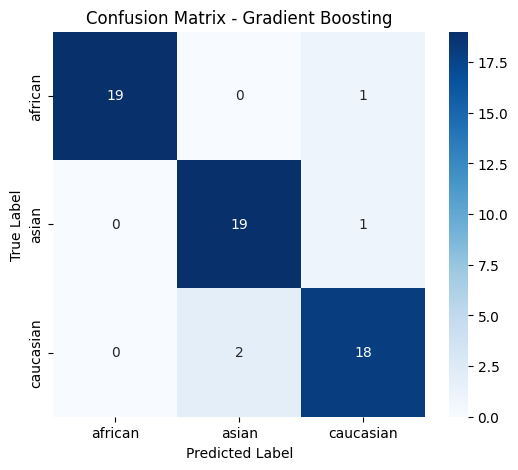

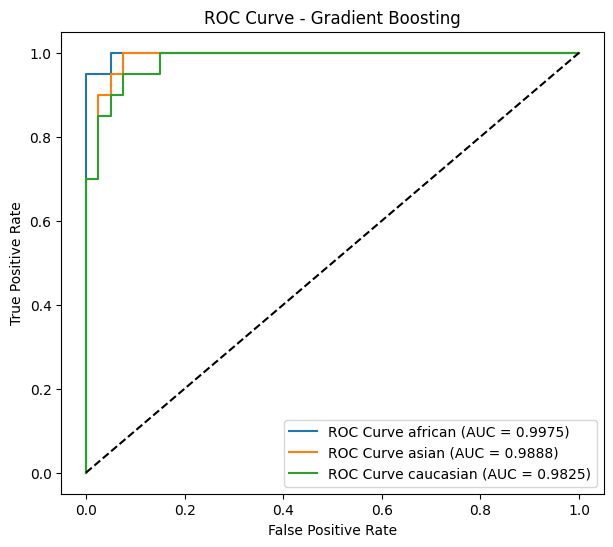

Gradient Boosting - Classification Report (Train):
              precision    recall  f1-score   support

     african     1.0000    1.0000    1.0000        80
       asian     1.0000    1.0000    1.0000        80
   caucasian     1.0000    1.0000    1.0000        80

    accuracy                         1.0000       240
   macro avg     1.0000    1.0000    1.0000       240
weighted avg     1.0000    1.0000    1.0000       240

Training Accuracy: 1.0

Gradient Boosting - Classification Report (Test):
              precision    recall  f1-score   support

     african     1.0000    0.9500    0.9744        20
       asian     0.9048    0.9500    0.9268        20
   caucasian     0.9000    0.9000    0.9000        20

    accuracy                         0.9333        60
   macro avg     0.9349    0.9333    0.9337        60
weighted avg     0.9349    0.9333    0.9337        60

Test Accuracy: 0.9333333333333333



In [ ]:
# Train Gradient Boosting on full training set with CV=5
gb_clf = classifiers['Gradient Boosting']
gb_clf.fit(X_train_kmer_scaled, y_train_encoded)

# Predict on train and test sets
y_train_pred = gb_clf.predict(X_train_kmer_scaled)
y_test_pred = gb_clf.predict(X_test_kmer_scaled)

# Compute accuracies without rounding
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

# Compute gap
gap = train_accuracy - test_accuracy

# Overfitting condition: If gap is between 0.03 and 0.05 (inclusive), it's NOT overfitting
overfitting = "No" if 0.03 <= gap <= 0.05 else "Yes"

# Store results
df_results = pd.DataFrame([[5, train_accuracy, test_accuracy, gap, overfitting]],
                          columns=["CV Value", "Training Accuracy", "Test Accuracy", "Gap", "Overfitting"])
print(df_results)

ethnicity_labels = y_train.astype('category').cat.categories

# Confusion Matrix
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test_encoded, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ethnicity_labels, yticklabels=ethnicity_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()


# ROC Curve
plt.figure(figsize=(7,6))
for i, label in enumerate(ethnicity_labels):
    fpr, tpr, _ = roc_curve(y_test_encoded == i, gb_clf.predict_proba(X_test_kmer_scaled)[:, i])
    plt.plot(fpr, tpr, label=f"ROC Curve {label} (AUC = {auc(fpr, tpr):.4f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting")
plt.legend()
plt.show()

# Print classification reports with accuracy included
train_report = classification_report(y_train_encoded, y_train_pred, target_names=ethnicity_labels, digits=4)
test_report = classification_report(y_test_encoded, y_test_pred, target_names=ethnicity_labels, digits=4)

print(f"Gradient Boosting - Classification Report (Train):\n{train_report}")
print(f"Training Accuracy: {train_accuracy}\n")

print(f"Gradient Boosting - Classification Report (Test):\n{test_report}")
print(f"Test Accuracy: {test_accuracy}\n")
